# Calibration of dgemm

Here, we will take as a model:

$T(m, n, k) = \alpha + \beta mn + \gamma mk + \delta nk + \zeta mnk + |\mathcal{N}(0, \sigma(m, n, k)|$

Where the noise parameter has itself a model:
$\sigma(m, n, k) = \eta + \theta mn + \lambda mk + \nu nk + \rho mnk$

In a first time, we will take a normal noise and not a half-normal, since it should be easier.

## Normal noise

In [1]:
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
import pystan
import matplotlib.pyplot as plt
import numpy
import statsmodels.formula.api as st
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_sizes(N, target_product):
    '''
    Return a list of N random sizes such that their product is close to the target (would be exactly the target without the rounding).
    Warning: the tuple is biased, only the last size can be greater than target_product**(1/N).
    '''
    if N == 1:
        return [target_product]
    s = round(numpy.random.uniform(1, target_product**(1/N)))
    return [s] + get_sizes(N-1, round(target_product/s))

def generate_polynomial_fit(intercept, coeff_mn, coeff_mk, coeff_nk, coeff_mnk, N=1000, max_prod=1e10, seed=42):
    numpy.random.seed(seed)
    df = []
    products = [int(10**numpy.random.uniform(1, 10.3)) for _ in range(N)]
    for max_prod in products:
        sizes = get_sizes(3, max_prod)
        numpy.random.shuffle(sizes)
        m, n, k = sizes
        df.append({
            'm': m,
            'n': n,
            'k': k,
            'mnk': m*n*k,
            't': intercept + coeff_mn*m*n + coeff_mk*m*k + coeff_nk*n*k + coeff_mnk*m*n*k
        })
    return pandas.DataFrame(df)

def generate_dataset(params_raw, params_noise, halfnormal=False, seed=42):
    df = generate_polynomial_fit(*params_raw, seed=seed)
    noise_sigma = generate_polynomial_fit(*params_noise, seed=seed)
    noise_sigma['noise'] = numpy.random.normal(0, 1, len(noise_sigma))
    if halfnormal:
        noise_sigma['noise'] = numpy.abs(noise_sigma['noise'])
    noise_sigma.head()
    noise_sigma['noise'] *= noise_sigma['t']
    df['t'] += noise_sigma['noise']
    return df

df = generate_dataset(
        params_raw = (3e-7, 1.4e-10, 2.1e-9, 3.3e-9, 6.3e-11),
        params_noise = (1e-7, 8.3e-12, 1.5e-10, 9.9e-11, 2.9e-12)
)

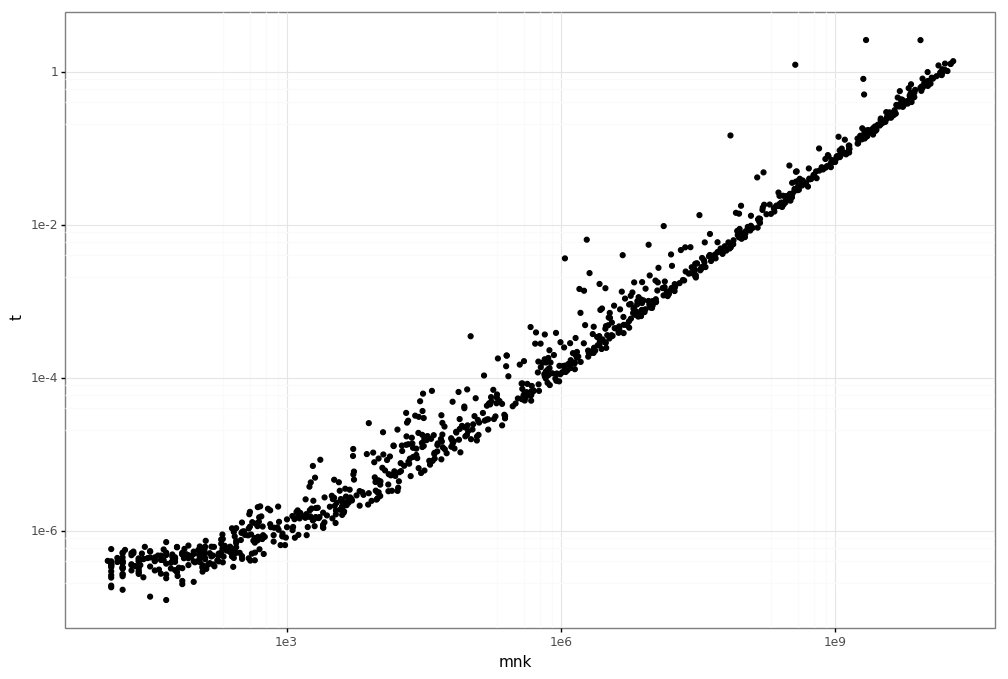

<ggplot: (-9223363271135692130)>

In [2]:
ggplot(df, aes(x='mnk', y='t')) + geom_point() + theme_bw() + scale_x_log10() + scale_y_log10()

In [3]:
%%time

model_code = """
data {
    int<lower=1> nb_points;
    vector<lower=0>[nb_points] M; // real X[N] does not work
    vector<lower=0>[nb_points] N;
    vector<lower=0>[nb_points] K;
    vector<lower=0>[nb_points] T;
}
transformed data {
  vector<lower=0>[nb_points] MN =  M .* N; // element-wise product
  vector<lower=0>[nb_points] MK =  M .* K;
  vector<lower=0>[nb_points] NK =  N .* K;
  vector<lower=0>[nb_points] MNK = M .* N .* K;
}
parameters {
    real<lower=0> intercept;
    real<lower=0> coeff_mn;
    real<lower=0> coeff_mk;
    real<lower=0> coeff_nk;
    real<lower=0> coeff_mnk;

    real<lower=0> intercept_noise;
    real<lower=0> coeff_mn_noise;
    real<lower=0> coeff_mk_noise;
    real<lower=0> coeff_nk_noise;
    real<lower=0> coeff_mnk_noise;
}
model {
    T ~ normal(intercept       + coeff_mn*MN       + coeff_mk*MK       + coeff_nk*NK       + coeff_mnk*MNK,
               intercept_noise + coeff_mn_noise*MN + coeff_mk_noise*MK + coeff_nk_noise*NK + coeff_mnk_noise*MNK);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6d851eb725dc8cbf2dca1a17286c9cb NOW.


CPU times: user 801 ms, sys: 50.7 ms, total: 852 ms
Wall time: 50.4 s


Inference for Stan model: anon_model_b6d851eb725dc8cbf2dca1a17286c9cb.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept       3.1e-7 1.5e-10 7.0e-9 2.9e-7 3.0e-7 3.1e-7 3.1e-7 3.2e-7   2093    1.0
coeff_mn       1.3e-10 1.2e-135.1e-121.2e-101.3e-101.3e-101.3e-101.4e-10   1872    1.0
coeff_mk        2.1e-9 3.7e-132.0e-11 2.1e-9 2.1e-9 2.1e-9 2.1e-9 2.1e-9   2778    1.0
coeff_nk        3.3e-9 2.3e-131.3e-11 3.3e-9 3.3e-9 3.3e-9 3.3e-9 3.3e-9   2981    1.0
coeff_mnk      6.3e-11 3.9e-152.1e-136.3e-116.3e-116.3e-116.3e-116.3e-11   2811    1.0
intercept_noise 1.0e-7 1.2e-10 5.2e-9 9.2e-8 9.8e-8 1.0e-7 1.0e-7 1.1e-7   1927    1.0
coeff_mn_noise 3.6e-12 6.5e-142.8e-121.3e-131.4e-122.9e-125.1e-121.1e-11   1924    1.0
coeff_mk_noise 1.6e-10 3.1e-131.4e-111.4e-101.5e-101.6e-101.7e-101.9e-10   2021    1.0
coeff_nk_noise 7.9e-11 2.1e-139

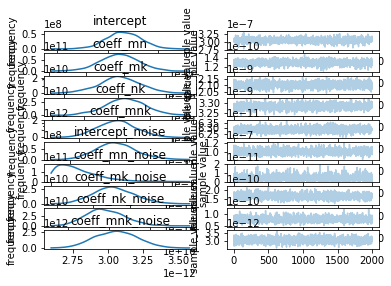

In [4]:
%%time

data=dict(nb_points=len(df), M=df['m'], N=df['n'], K=df['k'], T=df['t'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [5]:
def get_generated_data(fit):
    fit = fit.extract()
    return (
        (fit['intercept'].mean(), fit['coeff_mn'].mean(), fit['coeff_mk'].mean(), fit['coeff_nk'].mean(), fit['coeff_mnk'].mean()),
        (fit['intercept_noise'].mean(), fit['coeff_mn_noise'].mean(), fit['coeff_mk_noise'].mean(), fit['coeff_nk_noise'].mean(), fit['coeff_mnk_noise'].mean())
    )

params = get_generated_data(fit)
params

((3.063007587825931e-07,
  1.287677672054868e-10,
  2.1017512041735725e-09,
  3.284964456656608e-09,
  6.290496048249018e-11),
 (1.0178235173051983e-07,
  3.5745845908821555e-12,
  1.640511354112397e-10,
  7.85157758345324e-11,
  3.0588551102438093e-12))

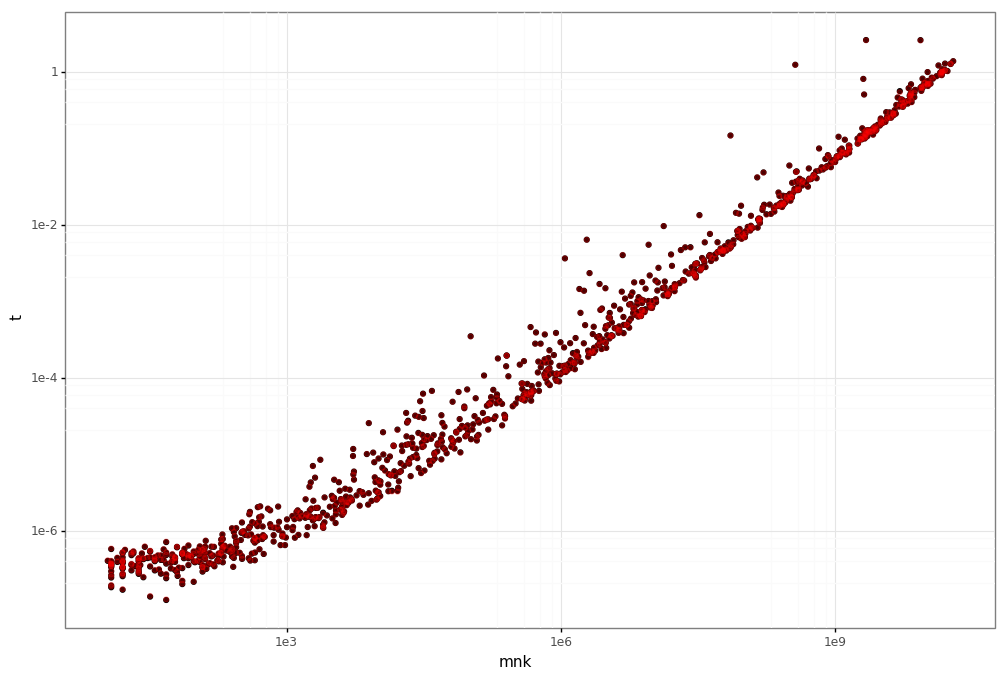

<ggplot: (-9223363271136619797)>

In [6]:
reg = generate_dataset(*params)
ggplot(df, aes(x='mnk', y='t')) + geom_point() + geom_point(data=reg, color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

In [7]:
reg['t'].describe()

count    1.000000e+03
mean     6.925570e-02
std      2.239659e-01
min      1.280258e-07
25%      1.524250e-06
50%      7.949914e-05
75%      7.359691e-03
max      2.584761e+00
Name: t, dtype: float64

In [8]:
df['t'].describe()

count    1.000000e+03
mean     6.944687e-02
std      2.247627e-01
min      1.256597e-07
25%      1.522771e-06
50%      7.974028e-05
75%      7.378808e-03
max      2.603469e+00
Name: t, dtype: float64

## Fitting a simple half-normal distribution

We have $Y = \mu + |X|$ for some (unobserved) $X \sim \mathcal{N}(0, \sigma)$. The goal is to find $\mu$ and $\sigma$.

We have to play with the log-likelihood.

Links:
- https://stackoverflow.com/questions/31169927/is-it-possible-to-define-a-stan-model-in-terms-of-an-arbitrary-posterior-functio
- https://groups.google.com/forum/#!msg/stan-users/4gv3fNCqSNk/4dwmJj1YwbsJ
- https://en.wikipedia.org/wiki/Half-normal_distribution

Basically, we can fit any distribution whose density can be written in closed form, just add the log of this density to the target.

If $X \sim \mathcal(0, \sigma^2)$, then the density function for $|X|$ can be written as follow, according to Wikipedia:

$$f(x) = \frac{\sqrt{2}}{\sigma\sqrt{\pi}}\exp \left( -\frac{x^2}{2\sigma^2} \right) \quad x \geq 0$$

So, if we take $Y = \mu + |X|$, its density function should be:

$$g(x) = \frac{\sqrt{2}}{\sigma\sqrt{\pi}}\exp \left( -\frac{(x-\mu)^2}{2\sigma^2} \right) \quad x \geq \mu$$

Funny, it looks very similar to the density function of the normal distribution.

Then, the log of this function is:

$$\log g(x) = \log(\frac{\sqrt{2}}{\sigma\sqrt{\pi}}) -\frac{(x-\mu)^2}{2\sigma^2} \quad x \geq \mu$$

For $x \leq \mu$, the density is $0$, so the log should probably be $-\infty$

In [9]:
%%time

model_code = """
data {
    int<lower=1> nb_points;
    vector[nb_points] Y;
}
parameters {
    real mu;
    real sigma;
}
model {
    for (i in 1:nb_points) {
        if(Y[i] > mu) {
            target += log(sqrt(2)/(sigma*sqrt(pi()))) - (pow(Y[i]-mu, 2))/(2*sigma*sigma);
        }
        else {
            target += negative_infinity();
        }
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bfd22c6442a22344e81caa0304940230 NOW.


CPU times: user 785 ms, sys: 37.2 ms, total: 822 ms
Wall time: 48 s


Inference for Stan model: anon_model_bfd22c6442a22344e81caa0304940230.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.23  3.9e-5 9.7e-4   1.23   1.23   1.23   1.23   1.23    623   1.01
sigma   0.77  1.7e-3   0.02   0.74   0.76   0.77   0.79   0.81    117   1.05
lp__  -471.5    0.08   1.23 -474.5 -472.0 -471.2 -470.6 -470.0    266   1.02

Samples were drawn using NUTS at Thu Feb  7 16:38:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 163 ms, sys: 54.4 ms, total: 218 ms
Wall time: 7.42 s


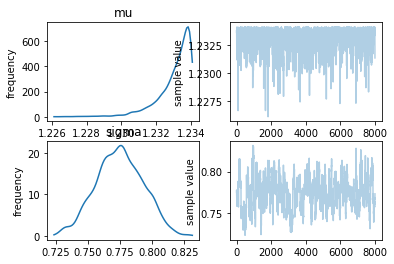

In [10]:
%%time

data=dict(nb_points=1000, Y=1.234+numpy.abs(numpy.random.normal(0, 0.789, 1000)))

fit = sm.sampling(data=data, iter=2000, chains=8)

print(fit)

fit.plot()

Inference for Stan model: anon_model_bfd22c6442a22344e81caa0304940230.
8 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.23  1.8e-5 9.9e-4   1.23   1.23   1.23   1.23   1.23   3071    1.0
sigma   0.78  3.6e-4   0.02   0.74   0.76   0.78   0.79   0.81   2266    1.0
lp__  -471.4    0.02   1.24 -474.6 -471.9 -471.1 -470.5 -470.0   3056    1.0

Samples were drawn using NUTS at Thu Feb  7 16:38:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 958 ms, sys: 1.25 s, total: 2.21 s
Wall time: 22 s


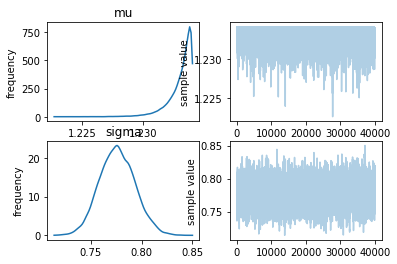

In [11]:
%%time

fit = sm.sampling(data=data, iter=10000, chains=8)

print(fit)

fit.plot()

Inference for Stan model: anon_model_bfd22c6442a22344e81caa0304940230.
8 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.23  1.9e-5 1.0e-3   1.23   1.23   1.23   1.23   1.23   2899    1.0
sigma   0.78  4.1e-4   0.02   0.74   0.76   0.78   0.79   0.81   1771    1.0
lp__  -471.4    0.02   1.26 -474.7 -472.0 -471.1 -470.5 -470.0   2684    1.0

Samples were drawn using NUTS at Thu Feb  7 16:42:28 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 1 s, sys: 1.32 s, total: 2.32 s
Wall time: 3min 51s


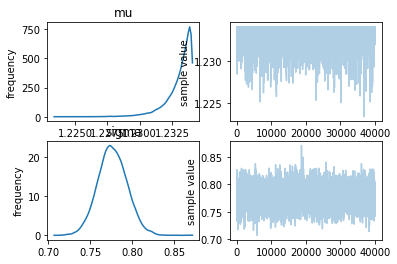

In [12]:
%%time

fit = sm.sampling(data=data, iter=10000, chains=8, control=dict(adapt_delta=0.95))

print(fit)

fit.plot()

I could not get rid of this warning, but the result is good anyway, so maybe we don't care?